[-2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 

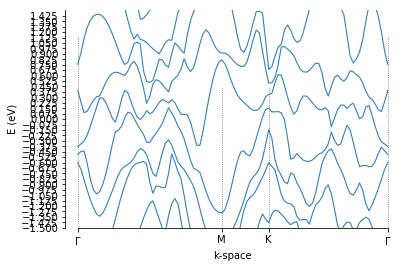

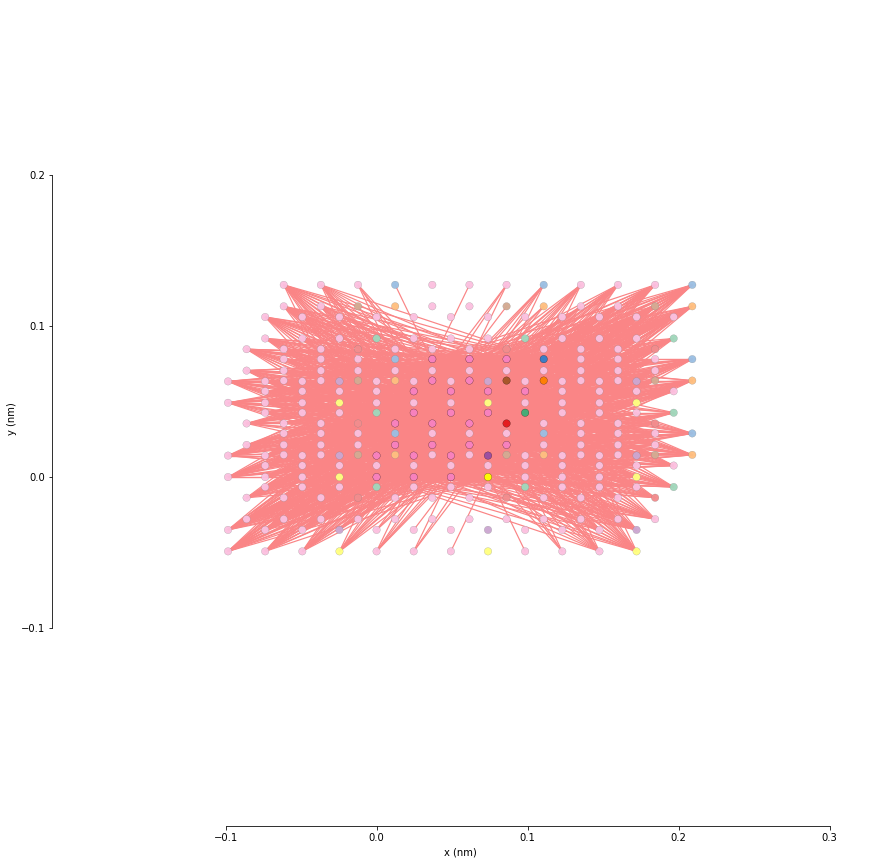

In [16]:
import pybinding as pb
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import re
import sys

from scipy.spatial import cKDTree
from math import pi, sqrt
from pybinding.repository.graphene import a, a_cc, t

c0 = 0.335  # [nm] graphene interlayer spacing
# Constants and hopping values based on Kooshino's paper
V0_pi = t  # [eV] graphene NN intralayer hopping
V0_sigma = 0.48  # [eV] graphene NN interlayer hopping
rc = 0.614  # [nm] hopping fitting parameter
lc = 0.0265  # [nm] hopping fitting parameter
q_sigma = c0 * 22.2  # [nm] hopping fitting parameter
q_pi = a_cc * 22.2  # [nm] hopping fitting parameter
r0 = 0.184 * a  # [nm] hopping fitting parameter


def find_row_and_col_inter(positions, positions_pbc, d_min_inter, d_max_inter):
    """ Find indexes for interlayer neighbours
    positions : np.ndarray
        Position of sites.
    positions_to : np.ndarray
        Position of sites that are being connected.
    l1, l2 : np.array, np.array
        Unit cell vectors.
    d_min_intra, d_max_intra : float, float
        Min and max distance for interlayer neighbour.

    Returns
    -------
    np.array, np.array
        Index of hopping from , index of hopping to.
    """

    z = positions[:, 2]
    layer1 = np.logical_and(z < c0 / 2, z > -c0 / 2)
    layer2 = z > c0 / 2

    row1, col1 = [], []
    if np.logical_and(np.any(layer1), np.any(layer2)):
        kdtree1 = cKDTree(positions[layer1])
        kdtree2 = cKDTree(positions_pbc[layer2])

        abs_idx1 = np.flatnonzero(layer1)
        abs_idx2 = np.flatnonzero(layer2)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter
        row1, col1 = abs_idx1[coo.row[idx]], abs_idx2[coo.col[idx]]

    layer3 = z < -c0 / 2
    row2, col2 = [], []

    if np.logical_and(np.any(layer1), np.any(layer3)):
        kdtree1 = cKDTree(positions[layer1])
        kdtree2 = cKDTree(positions_pbc[layer3])

        abs_idx1 = np.flatnonzero(layer1)
        abs_idx2 = np.flatnonzero(layer3)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter
        row2, col2 = abs_idx1[coo.row[idx]], abs_idx2[coo.col[idx]]

    return np.array(np.concatenate((row1, row2))).astype(np.int64), np.array(np.concatenate((col1, col2))).astype(
        np.int64)


def find_row_and_col_inter_pbc(positions, positions_pbc, d_min_inter, d_max_inter):
    """ Find indexes for interlayer neighbours
    positions : np.ndarray
        Position of sites.
    positions_to : np.ndarray
        Position of sites that are being connected.
    l1, l2 : np.array, np.array
        Unit cell vectors.
    d_min_intra, d_max_intra : float, float
        Min and max distance for interlayer neighbour.

    Returns
    -------
    np.array, np.array
        Index of hopping from , index of hopping to.
    """

    z = positions[:, 2]
    layer1 = np.logical_and(z < c0 / 2, z > -c0 / 2)
    layer2 = z > c0 / 2

    row1, col1 = [], []
    if np.logical_and(np.any(layer1), np.any(layer2)):
        kdtree1 = cKDTree(positions[layer1])
        kdtree2 = cKDTree(positions_pbc[layer2])

        abs_idx1 = np.flatnonzero(layer1)
        abs_idx2 = np.flatnonzero(layer2)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter
        row, col = abs_idx1[coo.row[idx]], abs_idx2[coo.col[idx]]

        kdtree1 = cKDTree(positions[layer2])
        kdtree2 = cKDTree(positions_pbc[layer1])

        abs_idx1 = np.flatnonzero(layer2)
        abs_idx2 = np.flatnonzero(layer1)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter
        row_inv_lay = abs_idx1[coo.row[idx]]
        col_inv_lay = abs_idx2[coo.col[idx]]

        row1 = np.append(row, row_inv_lay)
        col1 = np.append(col, col_inv_lay)

    layer3 = z < -c0 / 2
    row2, col2 = [], []

    if np.logical_and(np.any(layer1), np.any(layer3)):
        kdtree1 = cKDTree(positions[layer1])
        kdtree2 = cKDTree(positions_pbc[layer3])

        abs_idx1 = np.flatnonzero(layer1)
        abs_idx2 = np.flatnonzero(layer3)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter
        row, col = abs_idx1[coo.row[idx]], abs_idx2[coo.col[idx]]

        kdtree1 = cKDTree(positions[layer3])
        kdtree2 = cKDTree(positions_pbc[layer1])

        abs_idx1 = np.flatnonzero(layer3)
        abs_idx2 = np.flatnonzero(layer1)

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_inter, output_type='coo_matrix')

        idx = coo.data > d_min_inter

        row_inv_lay = abs_idx1[coo.row[idx]]
        col_inv_lay = abs_idx2[coo.col[idx]]

        row2 = np.append(row, row_inv_lay)
        col2 = np.append(col, col_inv_lay)

    return np.array(np.concatenate((row1, row2))).astype(np.int64), np.array(np.concatenate((col1, col2))).astype(
        np.int64)


def find_row_and_col_intra(positions, positions_to, d_min_intra, d_max_intra):
    """ Find indexes for intralayer neighbours
    positions : np.ndarray
        Position of sites.
    positions_to : np.ndarray
        Position of sites that are being connected.
    l1, l2 : np.array, np.array
        Unit cell vectors.
    d_min_intra, d_max_intra : float, float
        Min and max distance for intralayer neighbour.

    Returns
    -------
    np.array, np.array
        Index of hopping from , index of hopping to.
    """

    def find_neigh_in_layer(layer):

        kdtree1 = cKDTree(data=positions[layer])
        kdtree2 = cKDTree(data=positions_to[layer])

        coo = kdtree1.sparse_distance_matrix(kdtree2, d_max_intra, output_type='coo_matrix')
        abs_idx = np.flatnonzero(layer)

        idx = coo.data > d_min_intra
        row, col = abs_idx[coo.row[idx]], abs_idx[coo.col[idx]]
        return row, col

    z = positions[:, 2]
    layer1 = np.logical_and(z < c0 / 2, z > -c0 / 2)
    layer2 = z > c0 / 2
    layer3 = z < -c0 / 2
    row1, col1, row2, col2, row3, col3 = [], [], [], [], [], []
    if np.any(layer1):
        row1, col1 = find_neigh_in_layer(layer1)
    if np.any(layer2):
        row2, col2 = find_neigh_in_layer(layer2)
    if np.any(layer3):
        row3, col3 = find_neigh_in_layer(layer3)

    row = np.concatenate((row1, row2, row3))
    col = np.concatenate((col1, col2, col3))

    return row.astype(np.int64), col.astype(np.int64)


def periodic_neighbors(positions, l1, l2, d_min_inter, d_max_inter, d_min_intra, d_max_intra):
    """Find periodic neighbours based on the image algorithm
    Make images and find neighbours.
    No need to do +L and -L. One is enough, the other is automatically added to the lattice.

    positions : np.ndarray
        Position of sites.
    l1, l2 : np.array, np.array
        Unit cell vectors.
    d_min_intra, d_max_intra, d_min_inter, d_max_inter : float, float, float, float
        Min and max distance for intra and interlayer neighbours.

    Returns
    -------
    np.array, np.array, np.ndarray
        Index of hopping from , index of hopping to, unit cell reference index for all images, PBC.
    """

    # -l1
    positions_pbc = copy.deepcopy(positions)
    positions_pbc[:, 0] -= l1[0]
    positions_pbc[:, 1] -= l1[1]
    row_intra, col_intra = find_row_and_col_intra(positions, positions_pbc, d_min_intra, d_max_intra)
    row_inter, col_inter = find_row_and_col_inter_pbc(positions, positions_pbc, d_min_inter, d_max_inter)
    row1, col1 = np.append(row_intra, row_inter), np.append(col_intra, col_inter)
    pbc_cell1 = np.column_stack((-np.ones(row1.shape[0], dtype=np.int), np.zeros(row1.shape[0], dtype=np.int)))

    # -l2
    positions_pbc = copy.deepcopy(positions)
    positions_pbc[:, 0] -= l2[0]
    positions_pbc[:, 1] -= l2[1]
    row_intra, col_intra = find_row_and_col_intra(positions, positions_pbc, d_min_intra, d_max_intra)
    row_inter, col_inter = find_row_and_col_inter_pbc(positions, positions_pbc, d_min_inter, d_max_inter)
    row3, col3 = np.append(row_intra, row_inter), np.append(col_intra, col_inter)
    pbc_cell3 = np.column_stack((np.zeros(row3.shape[0], dtype=np.int), -np.ones(row3.shape[0], dtype=np.int)))

    # -l1 - l2
    positions_pbc = copy.deepcopy(positions)
    positions_pbc[:, 0] -= l1[0] + l2[0]
    positions_pbc[:, 1] -= l1[1] + l2[1]
    row_intra, col_intra = find_row_and_col_intra(positions, positions_pbc, d_min_intra, d_max_intra)
    row_inter, col_inter = find_row_and_col_inter_pbc(positions, positions_pbc, d_min_inter, d_max_inter)
    row5, col5 = np.append(row_intra, row_inter), np.append(col_intra, col_inter)
    pbc_cell5 = np.column_stack((-np.ones(row5.shape[0], dtype=np.int), -np.ones(row5.shape[0], dtype=np.int)))

    # -l1 + l2
    positions_pbc = copy.deepcopy(positions)
    positions_pbc[:, 0] -= l1[0] - l2[0]
    positions_pbc[:, 1] -= l1[1] - l2[1]
    row_intra, col_intra = find_row_and_col_intra(positions, positions_pbc, d_min_intra, d_max_intra)
    row_inter, col_inter = find_row_and_col_inter_pbc(positions, positions_pbc, d_min_inter, d_max_inter)
    row6, col6 = np.append(row_intra, row_inter), np.append(col_intra, col_inter)
    pbc_cell6 = np.column_stack((-np.ones(row6.shape[0], dtype=np.int), np.ones(row6.shape[0], dtype=np.int)))

    row = np.concatenate((row1, row3, row5, row6))
    col = np.concatenate((col1, col3, col5, col6))
    pbc_cell = np.concatenate((pbc_cell1, pbc_cell3, pbc_cell5, pbc_cell6))

    return row, col, pbc_cell


def unit_cell_neighbours(positions, d_min_intra, d_max_intra, d_min_inter, d_max_inter):
    """Find the neighbours inside the unit cell.

    Parameters
    ----------

    positions : np.ndarray
        Position of sites.
    d_min_intra, d_max_intra, d_min_inter, d_max_inter : float, float, float, float
        Min and max distance for intra and interlayer neighbours.

    Returns
    -------
    np.array, np.array, np.ndarray
        Index of hopping from , index of hopping to, unit cell reference index
    """
    positions_to = copy.deepcopy(positions)

    # find intralayer hopping
    row_intra, col_intra = find_row_and_col_intra(positions, positions_to, d_min_intra, d_max_intra)
    # find interlayer hopping
    row_inter, col_inter = find_row_and_col_inter(positions, positions_to, d_min_inter, d_max_inter)

    row, col = np.append(row_intra, row_inter), np.append(col_intra, col_inter)
    pbc_cell = np.column_stack((np.zeros(row.shape[0], dtype=np.int), np.zeros(row.shape[0], dtype=np.int)))

    return row, col, pbc_cell


def reciprocal_vectors(l1, l2):
    """Find reciprocal vectors.

    Parameters
    ----------

    l1, l2 : np.array, np.array
        Unit cell vectors.

    Returns
    -------
    list[np.array,np.array]
        Reciprocal vectors
    """
    n = l1.shape[0]
    mat = np.column_stack((l1, l2))[:n]
    mat = 2 * pi * np.linalg.inv(mat).T
    mat = np.vstack([mat, np.zeros(shape=(3 - n, n))])
    return [v.squeeze() for v in reversed(np.hsplit(mat, n))]


def load_ovito_lattice(name):
    """Load a lattice from a Ovito .xyz file. At the moment, works for files that have following format
       Type_id X_coord Y_coord Z_coord Data
       The point needs to have all 3 coordinates, and the approach is not general.

    Parameters
    ----------

    name : str
        Name of the xyz file

    Return
    ----------

        x, y, z coordinates, atom types and l1, l2, l3 unit cell vectors
    """
    __location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname("\Downloads\beomjin")))

    load_f = open(os.path.join(__location__, name), 'r')

    # read the atom number
    num_atoms = load_f.readline()

    # read the lattice vectors
    vectors = load_f.readline()
    vec = re.findall(r"[-+]?\d*\.*\d+", vectors)
    vec = list(map(float, vec))

    space_size = int(sqrt(len(vec)))

    _l1, _l2, _l3 = vec[0:space_size], vec[space_size:2 * space_size], vec[2 * space_size:3 * space_size]

    _atom_type = []
    _x_coord = []
    _y_coord = []
    _z_coord = []
    for line in load_f:
        atom = []
        for u in line.split():
            u = u.strip('\'')
            atom.append(u)
        _atom_type.append(atom[0])
        _x_coord.append(float(atom[1]) * 0.1)
        _y_coord.append(float(atom[2]) * 0.1)
        _z_coord.append(float(atom[3]) * 0.1)

    _x_coord = np.asarray(_x_coord)
    _y_coord = np.asarray(_y_coord)
    _z_coord = np.asarray(_z_coord)
    _atom_type = np.asarray(_atom_type)

    return _x_coord, _y_coord, _z_coord, _atom_type, _l1, _l2, _l3


def make_lattice(a1, a2, atom_type, positions, different_atoms, onsite_potential):
    """Import the loaded atoms to the lattice

    Parameters
    ----------

    a1, a2 : Tuple[float, float, float]
        Unit cell vectors
    atom_type : np.ndarray
        Sublattice labels.
    positions : np.ndarray
        Position of sites.
    different_atoms : list[str]
        Atom types loaded from XYZ
    onsite_potential : list[float]
        Onsite energy at each sublattice.

    Return
    ----------
        pb.Lattice lattice defined without the hopping terms

    """
    lat = pb.Lattice(a1=a1, a2=a2)
    list_atoms_sublattice = []

    count = np.zeros(len(different_atoms), dtype=int)
    sublattice_added = []
    for [i, atom] in enumerate(positions):
        if atom_type[i] in different_atoms:
            j = different_atoms.index(atom_type[i])

            list_atoms_sublattice.append((different_atoms[j] + str(count[j]), atom, onsite_potential[j]))
            sublattice_added.append(atom_type[i])

            count[j] += 1

    lat.add_sublattices(*list_atoms_sublattice)

    return lat


def make_complete_lattice(lattice, row, col, cell, hoppings):
    """Import the loaded atoms to the lattice

    Parameters
    ----------

    lattice : pb.Lattice
        Reference lattice without hopping.
    row : np.ndarray
        Hopping from index.
    col : np.ndarray
        Hopping to index.
    cell : list[[int, int, int]]
        List of reference unit cells for each hopping.
    hoppings : np.array
        Hopping terms.

    Return
    ----------
    pb.Lattice lattice defined with the hopping terms

    """

    lat = pb.Lattice(a1=lattice.vectors[0][0:2], a2=lattice.vectors[1][0:2])

    sub_alias_id = {}

    # add each sublattice
    for key, value in lattice.sublattices.items():
        sub_alias_id[value.unique_id] = key

        lat.add_one_sublattice(
            key, value.position, value.energy
        )

    # add each hopping term
    for unit_cell, hopping, r, c in zip(cell, hoppings, row, col):
        lat.add_one_hopping(
            unit_cell, sub_alias_id[r], sub_alias_id[c], hopping
        )

    lat.min_neighbors = 1
    return lat


def calculate_hoppings(row, col, positions, cell, l1, l2):
    """Import the loaded atoms to the lattice

    Parameters
    ----------

    row : np.ndarray
        Hopping from index.
    col : np.ndarray
        Hopping to index.
    positions : np.ndarray
        Position of sites.
    cell : list[[int, int, int]]
        List of reference unit cells for each hopping.
    l1, l2 : np.array
        Unit cell vectors.
    Return
    ----------
        List of hopping terms.

    """

    x1, y1, z1 = positions[row, 0], positions[row, 1], positions[row, 2]

    x2, y2, z2 = positions[col, 0] + cell[:, 0] * l1[0] + cell[:, 1] * l2[0], \
                 positions[col, 1] + cell[:, 0] * l1[1] + cell[:, 1] * l2[1], \
                 positions[col, 2]

    dx, dy, dz = x1 - x2, y1 - y2, z1 - z2

    d = np.sqrt(np.square(dx) + np.square(dy) + np.square(dz))
    d = np.squeeze(np.asarray(d))
    dz = np.squeeze(np.asarray(dz))

    d = np.around(d, 6)

    v_pi = V0_pi * np.exp(q_pi * (1.0 - d / a_cc))
    v_sigma = V0_sigma * np.exp(q_sigma * (1.0 - d / c0))

    hopping = 0*v_pi * (1 - (dz / d) ** 2) + 0*v_sigma * (dz / d) ** 2 -2.8
    print (hopping)
    return hopping


angle = 0 #21.787
name = 'myPositions.xyz'.format(angle)

# load coordinates, atom types and lattice vectors
x_coord, y_coord, z_coord, atom_type, l1, l2, l3 = load_ovito_lattice(name)
l1 = np.array(l1[0:2]) / 10.
l2 = np.array(l2[0:2]) / 10.
positions = np.column_stack((x_coord, y_coord, z_coord))

# name for different sublattices, still every added atom to the model needs to have a different sublattice ID,
# and this is where the sublattice info is lost
different_atoms = ['C1', 'C2', 'C3', 'C4']
# different_atoms = ['0', '1', '2', '3']

# onsite potential in this case between layers
onsite_potential = [0, 0, 0, 0]

# min and max interlayer radius for neighbour search
d_min_intra, d_max_intra = 0.99 * a_cc, 4 * a_cc
# min and max intralayer radius for neighbour search
d_min_inter, d_max_inter = 0.98 * c0, 4 * a_cc

# make a lattice without hopping
lattice = make_lattice(l1, l2, atom_type, positions, different_atoms, onsite_potential)

# find periodic hopping
row_pbc, col_pbc, cell_pbc = periodic_neighbors(positions, l1=l1, l2=l2,
                                                d_min_inter=d_min_inter, d_max_inter=d_max_inter,
                                                d_min_intra=d_min_intra, d_max_intra=d_max_intra)
# find hopping inside the unit cell
row_unit, col_unit, cell_unit = unit_cell_neighbours(positions, d_min_inter=d_min_inter, d_max_inter=d_max_inter,
                                                     d_min_intra=d_min_intra, d_max_intra=d_max_intra)

# for hopping i, j (i < j) conjugated hopping (j, i) is added automatically. (i, i) needs to be added as a onsite energy
# not a hopping.
row_unit, col_unit, cell_unit = row_unit[row_unit < col_unit], col_unit[row_unit < col_unit], \
                                cell_unit[row_unit < col_unit]

row = np.concatenate((row_pbc, row_unit))
col = np.concatenate((col_pbc, col_unit))
cell = np.concatenate((cell_pbc, cell_unit))

# number of unit cells in a1 and a2 direction
num_a1, num_a2 = 1, 1

# calculate the hoppings based on the distance
hoppings = calculate_hoppings(row, col, positions, cell, l1, l2)
# make a full pb.Lattice with sites and hoppings
complete_lattice = make_complete_lattice(lattice, row, col, cell, hoppings)
# save the lattice
pb.save(complete_lattice, 'lattice_' + name[:-4])

# reciprocal vectors, defining a grid
b1, b2 = reciprocal_vectors(num_a1 * l1, num_a2 * l2)

model = pb.Model(complete_lattice,
                 pb.translational_symmetry(True, True),
                 )
pb.utils.tic()
num_points = 100
step = np.linalg.norm(b1) / num_points
# define a specific path
k11 = 1 / 3 * b1[0:2] + 2 / 3 * b2[0:2]
k21 = 2 / 3 * b1[0:2] + 1 / 3 * b2[0:2]
mp = (k11 + k21) / 2
# k_path doesn't allow specifying number of points only allows setting the step
points = [[0, 0], mp, k11, [0, 0]]
k_path = pb.make_path([0, 0], mp, k11, [0, 0], step=step)
# change the number of points to num_points
step = step * k_path.shape[0] / num_points
k_path = pb.make_path([0, 0], mp, k11, [0, 0], step=step)

solver = pb.solver.lapack(model)
bands = solver.calc_bands(*points, step=step)
bands.plot(['$\Gamma$', 'M', 'K', '$\Gamma$'])
ylim = 1.5
step = 0.05*ylim
plt.yticks(np.arange(-ylim,ylim,step))
plt.ylim(-ylim,ylim)
pb.utils.toc("Done in: ")
plt.show()

#plt.plot()
plt.figure(figsize=(15,15))
model.plot()#site={"radius": 0} , hopping ={'width':5, 'cmap': 'auto'})
plt.show()
